# Treinamento com interface de alto nível

- **Nome:** Nayla Cristina dos Santos Paixão
- **Email:** ncsp@cesar.school
- **Dataset:** https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

## Importação das bibliotecas

In [1]:
# http://pytorch.org/
from os.path import exists

import torch

In [2]:
!pip install -q kaggle

In [21]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from google.colab import files
import os
import zipfile
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Carregar os dados

In [6]:
# Fazer upload do arquivo kaggle.json
uploaded = files.upload()

# Mover o arquivo para o local correto
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

# Descompactar o arquivo
with zipfile.ZipFile('rice-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('rice-data')

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 98% 216M/219M [00:00<00:00, 513MB/s] 
100% 219M/219M [00:00<00:00, 554MB/s]


In [11]:
# Definir path e Classes
data_dir = '/content/rice-data/Rice_Image_Dataset'
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Função para carregar imagens
def load_images(data_dir, classes, img_size=(64,64), max_per_class=15000):
    images = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print(f'Carregando {class_name}')

        count = 0
        for img_name in os.listdir(class_dir):
            if count >= max_per_class:
                break

            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_idx)
                count += 1
            except Exception as e:
                print(f'Erro ao carregar {img_path}: {str(e)}')

    return np.array(images), np.array(labels)

# Carregar imagens
X, y = load_images(data_dir, classes, max_per_class=2000) #limitado para 2000
print(f'\nDataset carregado: {X.shape[0]} imagens')
print(f'Tamanho das imagens: {X.shape[1:]}')
print(f'Distribuição das classes: {np.bincount(y)}')

Carregando Arborio
Carregando Basmati
Carregando Ipsala
Carregando Jasmine
Carregando Karacadag

Dataset carregado: 10000 imagens
Tamanho das imagens: (64, 64, 3)
Distribuição das classes: [2000 2000 2000 2000 2000]


## Análise exploratória

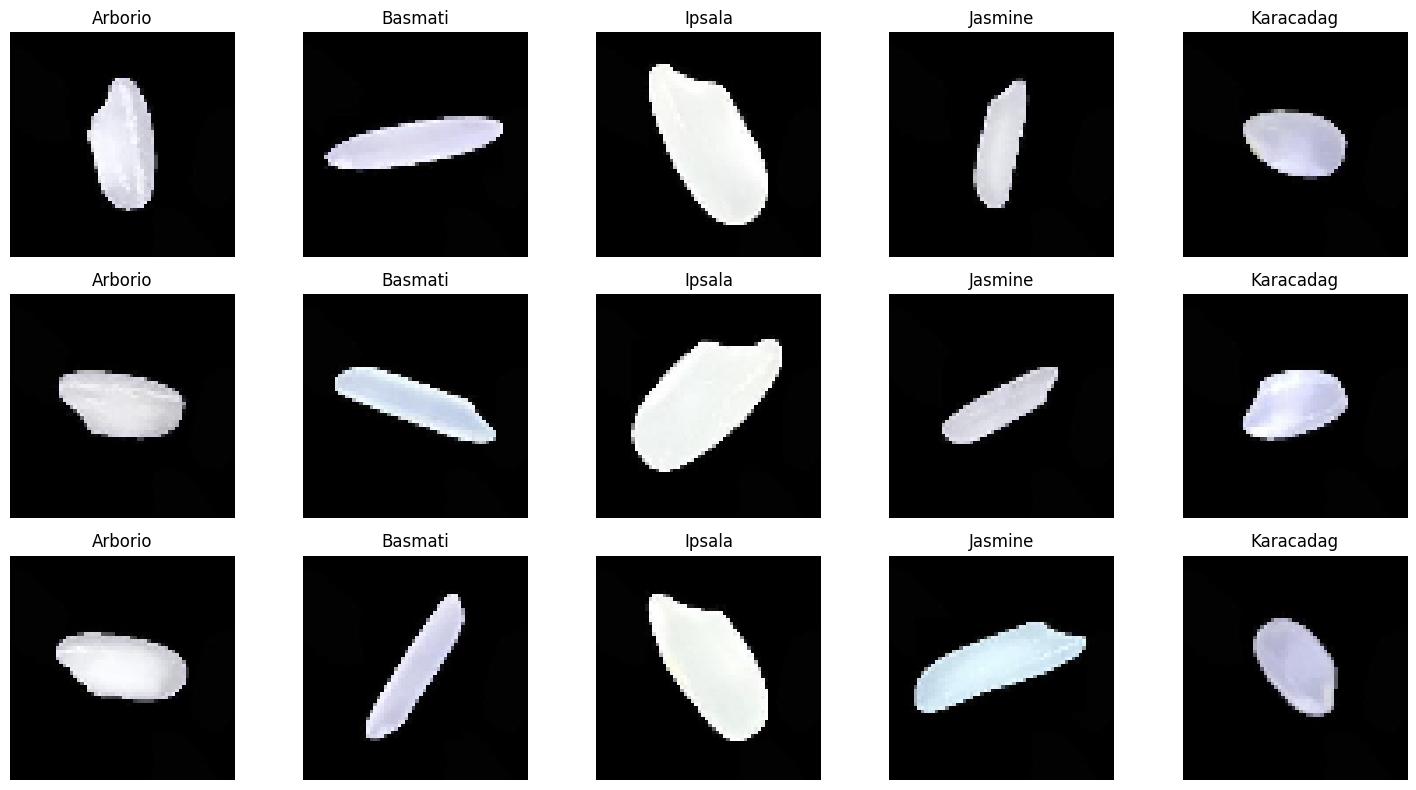

In [12]:
# Visualizar exemplos de cada classe
plt.figure(figsize=(15, 8))
for i in range(5):
    for j in range(3):
        idx = np.where(y == i)[0][j]
        plt.subplot(3, 5, j*5 + i + 1)
        plt.imshow(X[idx])
        plt.title(classes[i])
        plt.axis('off')
plt.tight_layout()
plt.show()

## Preparação dos dados para treinamento

In [111]:
# Divisão dos dados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [113]:
# Normalização

transform_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])


In [114]:
from torch.utils.data import Dataset
from PIL import Image
# Estrutura do dataset
class RiceDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.uint8)  # garantir formato correto
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Converter para PIL para aplicar transformações do torchvision
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [115]:
# Transformações e criacao de datasets e dataloaders

train_dataset = RiceDataset(X_train, y_train, transform=transform_pipeline)
val_dataset = RiceDataset(X_val, y_val, transform=transform_pipeline)
test_dataset = RiceDataset(X_test, y_test, transform=transform_pipeline)

In [116]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Criação da Rede

In [125]:
class RiceImageMLP(nn.Module):
    def __init__(self):
        super(RiceImageMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(64*64*3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 5),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RiceImageMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


## Treinamento

In [127]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [128]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Avaliação

In [129]:
# Avaliar no conjunto de teste
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Acurácia no Teste: {100 * correct / total:.2f}%')

Acurácia no Teste: 23.35%


##Gerando a matriz confusão

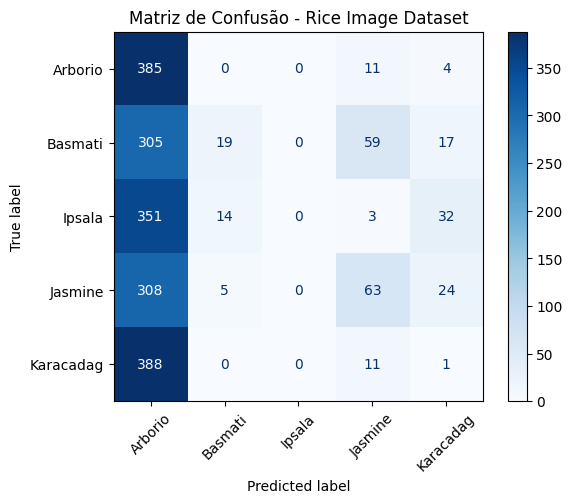

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(inputs.size(0), -1)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classes do dataset
classes = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão - Rice Image Dataset")
plt.show()

# Conclusões


- Temos um dataset de imagem de tipos de arroz, o objetivo é usar redes neurais para classifica-lo os tipos corretamente;
- Entretanto houve uma baixa acuracia do modelo, o que sugere que o modelo não conseguiu distinguir muito bem as classes;
- Outros fatores provavelmente, normalização, modelo pode esta complexo ou simples demais para o problema definido.
